In [1]:
#import important libraries
import warnings
warnings.filterwarnings("ignore")

import os
import glob
import matplotlib.pyplot as plt
# Keras API
from tensorflow import keras
from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.layers import Conv2D,MaxPooling2D,AveragePooling2D,BatchNormalization,Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense, Dropout, Activation, Flatten
#from tensorflow.keras.layers import Conv2D, MaxPooling2D,Concatenate
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from tensorflow.math import confusion_matrix 
import pickle
import time
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
#load the dataset from pickled files
pickle_in = open("X_BW.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("W_BW.pickle","rb")
W = pickle.load(pickle_in)
W=np.asarray(W)

pickle_in = open("Y_BW.pickle","rb")
y = pickle.load(pickle_in)
y = to_categorical(y)

In [3]:
print(type(X))
print(X.shape)
print(W.shape)
print(y.shape)

<class 'numpy.ndarray'>
(8068, 64, 64, 1)
(8068,)
(8068, 5)


In [4]:
#split into train and test datasets
#X.reshape((8181,3),64,64,1)
X_train,X_test,W_train,W_test,y_train,y_test=train_test_split(X,W,y,train_size=0.75,test_size=0.25,random_state=123)
print(X_test.shape)
print(W_test.shape)
print(y_test.shape)

(2017, 64, 64, 1)
(2017,)
(2017, 5)


In [5]:
from tensorflow.keras.utils import plot_model
from keras.layers.merge import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 60, 60, 128)  3328        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 30, 30, 128)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 30, 30, 128)  0           max_pooling2d[0][0]              
_______________________________________________________________________________________

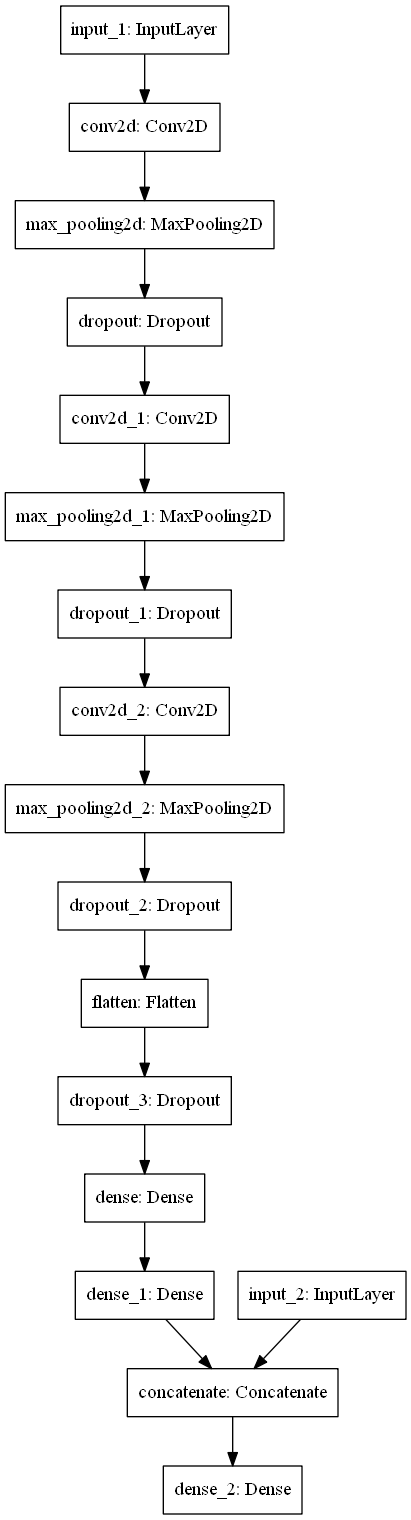

In [6]:
#Build the model
visible1 = Input(shape=(64,64,1))
#visible1 = Input(shape=(100,100,1))
# first feature extractor

conv1 = Conv2D(128, kernel_size=(5,5), activation='relu')(visible1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
dropout1=Dropout(0.2)(pool1)

conv2 = Conv2D(64, kernel_size=(3,3), activation='relu')(dropout1)
#conv2 = Conv2D(64, kernel_size=(3,3), activation='relu')
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
dropout2=Dropout(0.2)(pool2)

conv3 = Conv2D(64, kernel_size=(3,3), activation='relu')(dropout2)
#conv3 = Conv2D(64, kernel_size=(3,3), activation='relu')
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
dropout3=Dropout(0.2)(pool3)


flat1 = Flatten()(dropout3)
dropout4=Dropout(0.5)(flat1)
#### New entry to try concatentation
flat2 = Input(shape=(1))



#hidden1 = Dense(64, activation='relu')(merge)
hidden1 = Dense(64, activation='relu')(dropout4)
hidden2 = Dense(16, activation='relu')(hidden1)

hidden3 = Concatenate()([hidden2, flat2])
#regress=

## 

#output = Dense(5, activation='softmax')(hidden2)

output = Dense(5, activation='softmax')(hidden3)

model = Model(inputs=(visible1,flat2), outputs=output)
#model = Model(inputs=(visible1), outputs=output)
print(model.summary())
# plot graph
plot_model(model, to_file='convolutional_neural_network.png')

In [7]:
#Compile the model with hyperparameters
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', keras.metrics.Precision(),  keras.metrics.Recall()],
             )

In [9]:
#Run the model with 100 epochs
import time
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
start = time.perf_counter()
print(y_train.shape)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model_BW_weights.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history=model.fit((X_train,W_train), y_train, batch_size=64, epochs=100, validation_split=0.2,shuffle=1, callbacks=[es, mc], class_weight=None)

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

(6051, 5)
Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 1.3824 - accuracy: 0.5696 - precision: 0.6656 - recall: 0.4924
Epoch 00001: val_accuracy improved from -inf to 0.64740, saving model to best_model_BW_weights.h5
76/76 [==============================] - 50s 661ms/step - loss: 1.3824 - accuracy: 0.5696 - precision: 0.6656 - recall: 0.4924 - val_loss: 0.7938 - val_accuracy: 0.6474 - val_precision: 0.7939 - val_recall: 0.5376
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.7753 - accuracy: 0.6779 - precision: 0.7990 - recall: 0.5486
Epoch 00002: val_accuracy improved from 0.64740 to 0.68704, saving model to best_model_BW_weights.h5
76/76 [==============================] - 52s 679ms/step - loss: 0.7753 - accuracy: 0.6779 - precision: 0.7990 - recall: 0.5486 - val_loss: 0.7132 - val_accuracy: 0.6870 - val_precision: 0.8178 - val_recall: 0.6226
Epoch 3/100
76/76 [==============================] - ETA: 0s - loss: 0.6877 - accuracy: 0.7368 - pr

Epoch 21/100
76/76 [==============================] - ETA: 0s - loss: 0.2476 - accuracy: 0.9107 - precision: 0.9185 - recall: 0.9017
Epoch 00021: val_accuracy improved from 0.91495 to 0.91577, saving model to best_model_BW_weights.h5
76/76 [==============================] - 98s 1s/step - loss: 0.2476 - accuracy: 0.9107 - precision: 0.9185 - recall: 0.9017 - val_loss: 0.2770 - val_accuracy: 0.9158 - val_precision: 0.9226 - val_recall: 0.9050
Epoch 22/100
76/76 [==============================] - ETA: 0s - loss: 0.2501 - accuracy: 0.9089 - precision: 0.9171 - recall: 0.9010
Epoch 00022: val_accuracy did not improve from 0.91577
76/76 [==============================] - 97s 1s/step - loss: 0.2501 - accuracy: 0.9089 - precision: 0.9171 - recall: 0.9010 - val_loss: 0.2739 - val_accuracy: 0.9116 - val_precision: 0.9189 - val_recall: 0.8984
Epoch 23/100
76/76 [==============================] - ETA: 0s - loss: 0.2428 - accuracy: 0.9138 - precision: 0.9204 - recall: 0.9050
Epoch 00023: val_accura

Epoch 41/100
76/76 [==============================] - ETA: 0s - loss: 0.1747 - accuracy: 0.9382 - precision: 0.9436 - recall: 0.9331
Epoch 00041: val_accuracy did not improve from 0.92733
76/76 [==============================] - 95s 1s/step - loss: 0.1747 - accuracy: 0.9382 - precision: 0.9436 - recall: 0.9331 - val_loss: 0.2333 - val_accuracy: 0.9257 - val_precision: 0.9304 - val_recall: 0.9166
Epoch 42/100
76/76 [==============================] - ETA: 0s - loss: 0.1779 - accuracy: 0.9324 - precision: 0.9364 - recall: 0.9279
Epoch 00042: val_accuracy did not improve from 0.92733
76/76 [==============================] - 82s 1s/step - loss: 0.1779 - accuracy: 0.9324 - precision: 0.9364 - recall: 0.9279 - val_loss: 0.2281 - val_accuracy: 0.9249 - val_precision: 0.9315 - val_recall: 0.9207
Epoch 43/100
76/76 [==============================] - ETA: 0s - loss: 0.1741 - accuracy: 0.9353 - precision: 0.9389 - recall: 0.9300
Epoch 00043: val_accuracy did not improve from 0.92733
76/76 [=======

76/76 [==============================] - ETA: 0s - loss: 0.0976 - accuracy: 0.9634 - precision: 0.9650 - recall: 0.9622
Epoch 00081: val_accuracy did not improve from 0.93559
76/76 [==============================] - 39s 507ms/step - loss: 0.0976 - accuracy: 0.9634 - precision: 0.9650 - recall: 0.9622 - val_loss: 0.2298 - val_accuracy: 0.9323 - val_precision: 0.9358 - val_recall: 0.9265
Epoch 82/100
76/76 [==============================] - ETA: 0s - loss: 0.0872 - accuracy: 0.9686 - precision: 0.9701 - recall: 0.9667
Epoch 00082: val_accuracy improved from 0.93559 to 0.93642, saving model to best_model_BW_weights.h5
76/76 [==============================] - 38s 502ms/step - loss: 0.0872 - accuracy: 0.9686 - precision: 0.9701 - recall: 0.9667 - val_loss: 0.2476 - val_accuracy: 0.9364 - val_precision: 0.9371 - val_recall: 0.9356
Epoch 83/100
76/76 [==============================] - ETA: 0s - loss: 0.0983 - accuracy: 0.9649 - precision: 0.9664 - recall: 0.9634
Epoch 00083: val_accuracy impr

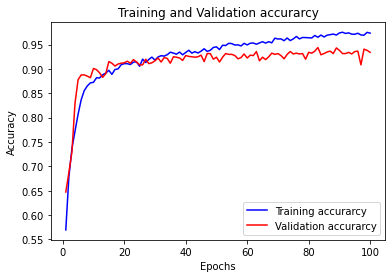

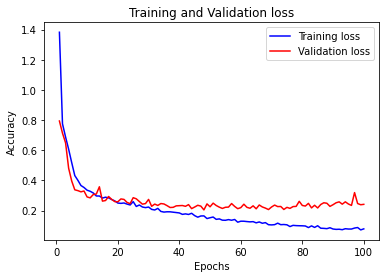

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
#Results on test dataset
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_BW_weights.h5')
y_pred = saved_model.predict((X_test,W_test), batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
print(y_pred_bool)
rounded_labels=np.argmax(y_test, axis=1)
print(rounded_labels)
print(classification_report(rounded_labels, y_pred_bool))

32/32 [==============================] - 5s 135ms/step
[0 4 4 ... 2 4 2]
[4 4 4 ... 2 4 2]
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       263
           1       0.90      0.32      0.47        28
           2       0.93      0.91      0.92       523
           3       1.00      1.00      1.00       523
           4       0.94      0.97      0.95       680

    accuracy                           0.93      2017
   macro avg       0.91      0.80      0.83      2017
weighted avg       0.93      0.93      0.93      2017



In [36]:
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_BW_weights.h5')

#score,accuracy,precision,recall = saved_model.evaluate(X_test,y_test,verbose=1)

score,accuracy,precision,recall = saved_model.evaluate((X_train,W_train),y_train,verbose=1)
print("train loss is {}".format(score))
print("train accuracy is {}".format(accuracy))
print("train Precision is {}".format(precision))
print("train Recall is {}".format(recall))
f1 = (2*(precision*recall))/(precision+recall)
print("train f1_score is {}".format(f1))

190/190 [==============================] - 11s 56ms/step - loss: 0.0673 - accuracy: 0.9853 - precision: 0.9861 - recall: 0.9840
train loss is 0.06729988753795624
train accuracy is 0.9852916598320007
train Precision is 0.9860880970954895
train Recall is 0.9839695692062378
train f1_score is 0.9850276940571979


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 60, 60, 128)  3328        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 30, 30, 128)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 30, 30, 128)  0           max_pooling2d[0][0]              
_______________________________________________________________________________________

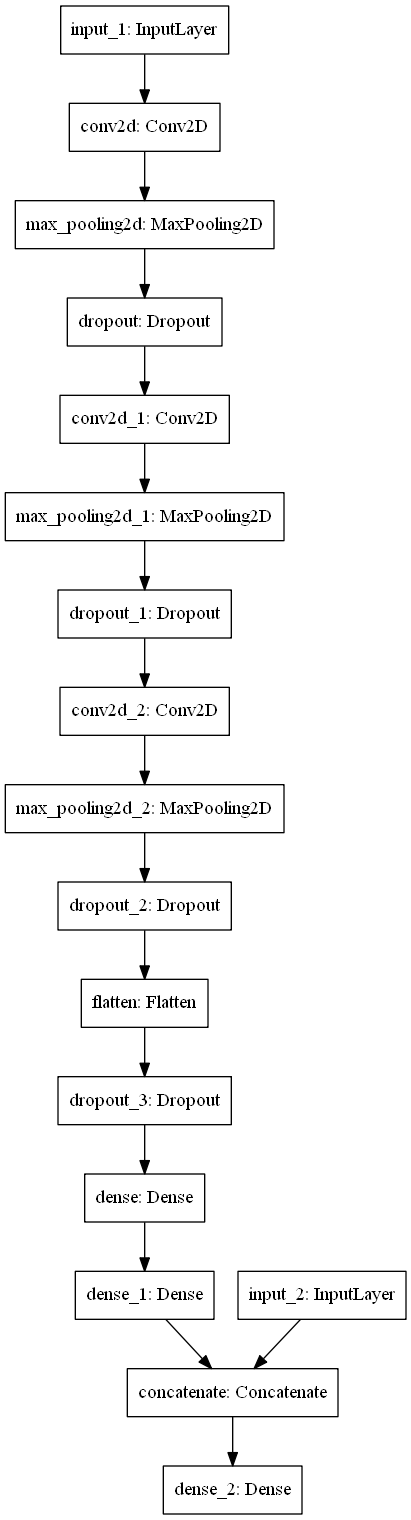

In [8]:
#Build the model
visible1 = Input(shape=(64,64,1))
#visible1 = Input(shape=(100,100,1))
# first feature extractor

conv1 = Conv2D(128, kernel_size=(5,5), activation='relu')(visible1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
dropout1=Dropout(0.2)(pool1)

conv2 = Conv2D(64, kernel_size=(3,3), activation='relu')(dropout1)
#conv2 = Conv2D(64, kernel_size=(3,3), activation='relu')
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
dropout2=Dropout(0.2)(pool2)

conv3 = Conv2D(64, kernel_size=(3,3), activation='relu')(dropout2)
#conv3 = Conv2D(64, kernel_size=(3,3), activation='relu')
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
dropout3=Dropout(0.2)(pool3)


flat1 = Flatten()(dropout3)
dropout4=Dropout(0.5)(flat1)
#### New entry to try concatentation
flat2 = Input(shape=(1))



#hidden1 = Dense(64, activation='relu')(merge)
hidden1 = Dense(64, activation='relu')(dropout4)
hidden2 = Dense(16, activation='relu')(hidden1)

hidden3 = Concatenate()([hidden2, flat2])
#regress=

## 

#output = Dense(5, activation='softmax')(hidden2)

output = Dense(5, activation='softmax')(hidden3)

model = Model(inputs=(visible1,flat2), outputs=output)
#model = Model(inputs=(visible1), outputs=output)
print(model.summary())
# plot graph
plot_model(model, to_file='convolutional_neural_network.png')

In [9]:
#Compile the model with hyperparameters
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', keras.metrics.Precision(),  keras.metrics.Recall()],
             )

In [10]:
#Run the model with 1000 epochs
import time
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
start = time.perf_counter()
print(y_train.shape)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model_BW_weights_1000.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history=model.fit((X_train,W_train), y_train, batch_size=64, epochs=1000, validation_split=0.2,shuffle=1, callbacks=[es, mc], class_weight=None)

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

(6051, 5)
Epoch 1/1000
76/76 [==============================] - ETA: 0s - loss: 1.9199 - accuracy: 0.6159 - precision: 0.6635 - recall: 0.5409
Epoch 00001: val_accuracy improved from -inf to 0.71841, saving model to best_model_BW_weights_1000.h5
76/76 [==============================] - 74s 974ms/step - loss: 1.9199 - accuracy: 0.6159 - precision: 0.6635 - recall: 0.5409 - val_loss: 0.7565 - val_accuracy: 0.7184 - val_precision: 0.7845 - val_recall: 0.5954
Epoch 2/1000
76/76 [==============================] - ETA: 0s - loss: 0.5613 - accuracy: 0.7690 - precision: 0.8220 - recall: 0.7165
Epoch 00002: val_accuracy improved from 0.71841 to 0.83072, saving model to best_model_BW_weights_1000.h5
76/76 [==============================] - 71s 937ms/step - loss: 0.5613 - accuracy: 0.7690 - precision: 0.8220 - recall: 0.7165 - val_loss: 0.4585 - val_accuracy: 0.8307 - val_precision: 0.8901 - val_recall: 0.7894
Epoch 3/1000
76/76 [==============================] - ETA: 0s - loss: 0.4615 - accuracy

Epoch 20/1000
76/76 [==============================] - ETA: 0s - loss: 0.2451 - accuracy: 0.9107 - precision: 0.9212 - recall: 0.9010
Epoch 00020: val_accuracy did not improve from 0.91742
76/76 [==============================] - 90s 1s/step - loss: 0.2451 - accuracy: 0.9107 - precision: 0.9212 - recall: 0.9010 - val_loss: 0.2458 - val_accuracy: 0.9125 - val_precision: 0.9214 - val_recall: 0.9001
Epoch 21/1000
76/76 [==============================] - ETA: 0s - loss: 0.2422 - accuracy: 0.9097 - precision: 0.9160 - recall: 0.9017
Epoch 00021: val_accuracy did not improve from 0.91742
76/76 [==============================] - 90s 1s/step - loss: 0.2422 - accuracy: 0.9097 - precision: 0.9160 - recall: 0.9017 - val_loss: 0.2850 - val_accuracy: 0.8968 - val_precision: 0.9175 - val_recall: 0.8819
Epoch 22/1000
76/76 [==============================] - ETA: 0s - loss: 0.2349 - accuracy: 0.9124 - precision: 0.9222 - recall: 0.9010
Epoch 00022: val_accuracy did not improve from 0.91742
76/76 [====

76/76 [==============================] - ETA: 0s - loss: 0.1347 - accuracy: 0.9479 - precision: 0.9519 - recall: 0.9448
Epoch 00060: val_accuracy did not improve from 0.92981
76/76 [==============================] - 71s 929ms/step - loss: 0.1347 - accuracy: 0.9479 - precision: 0.9519 - recall: 0.9448 - val_loss: 0.2463 - val_accuracy: 0.9174 - val_precision: 0.9242 - val_recall: 0.9166
Epoch 61/1000
76/76 [==============================] - ETA: 0s - loss: 0.1316 - accuracy: 0.9465 - precision: 0.9489 - recall: 0.9446
Epoch 00061: val_accuracy did not improve from 0.92981
76/76 [==============================] - 70s 921ms/step - loss: 0.1316 - accuracy: 0.9465 - precision: 0.9489 - recall: 0.9446 - val_loss: 0.2146 - val_accuracy: 0.9265 - val_precision: 0.9339 - val_recall: 0.9224
Epoch 62/1000
76/76 [==============================] - ETA: 0s - loss: 0.1236 - accuracy: 0.9541 - precision: 0.9562 - recall: 0.9519
Epoch 00062: val_accuracy did not improve from 0.92981
76/76 [============

Epoch 81/1000
76/76 [==============================] - ETA: 0s - loss: 0.0916 - accuracy: 0.9649 - precision: 0.9666 - recall: 0.9638
Epoch 00081: val_accuracy did not improve from 0.92981
76/76 [==============================] - 70s 915ms/step - loss: 0.0916 - accuracy: 0.9649 - precision: 0.9666 - recall: 0.9638 - val_loss: 0.2598 - val_accuracy: 0.9240 - val_precision: 0.9270 - val_recall: 0.9224
Epoch 82/1000
76/76 [==============================] - ETA: 0s - loss: 0.1016 - accuracy: 0.9593 - precision: 0.9602 - recall: 0.9576
Epoch 00082: val_accuracy did not improve from 0.92981
76/76 [==============================] - 60s 785ms/step - loss: 0.1016 - accuracy: 0.9593 - precision: 0.9602 - recall: 0.9576 - val_loss: 0.2595 - val_accuracy: 0.9290 - val_precision: 0.9302 - val_recall: 0.9240
Epoch 83/1000
76/76 [==============================] - ETA: 0s - loss: 0.0972 - accuracy: 0.9638 - precision: 0.9662 - recall: 0.9618
Epoch 00083: val_accuracy did not improve from 0.92981
76/76

Epoch 121/1000
76/76 [==============================] - ETA: 0s - loss: 0.0656 - accuracy: 0.9742 - precision: 0.9756 - recall: 0.9736
Epoch 00121: val_accuracy did not improve from 0.93229
76/76 [==============================] - 72s 951ms/step - loss: 0.0656 - accuracy: 0.9742 - precision: 0.9756 - recall: 0.9736 - val_loss: 0.2726 - val_accuracy: 0.9273 - val_precision: 0.9273 - val_recall: 0.9273
Epoch 122/1000
76/76 [==============================] - ETA: 0s - loss: 0.0765 - accuracy: 0.9719 - precision: 0.9731 - recall: 0.9717
Epoch 00122: val_accuracy did not improve from 0.93229
76/76 [==============================] - 72s 946ms/step - loss: 0.0765 - accuracy: 0.9719 - precision: 0.9731 - recall: 0.9717 - val_loss: 0.2633 - val_accuracy: 0.9249 - val_precision: 0.9278 - val_recall: 0.9232
Epoch 123/1000
76/76 [==============================] - ETA: 0s - loss: 0.0711 - accuracy: 0.9764 - precision: 0.9776 - recall: 0.9752
Epoch 00123: val_accuracy did not improve from 0.93229
76

76/76 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 0.9806 - precision: 0.9810 - recall: 0.9802
Epoch 00161: val_accuracy did not improve from 0.93642
76/76 [==============================] - 76s 994ms/step - loss: 0.0511 - accuracy: 0.9806 - precision: 0.9810 - recall: 0.9802 - val_loss: 0.3418 - val_accuracy: 0.9273 - val_precision: 0.9280 - val_recall: 0.9257
Epoch 162/1000
76/76 [==============================] - ETA: 0s - loss: 0.0426 - accuracy: 0.9851 - precision: 0.9853 - recall: 0.9847
Epoch 00162: val_accuracy did not improve from 0.93642
76/76 [==============================] - 75s 982ms/step - loss: 0.0426 - accuracy: 0.9851 - precision: 0.9853 - recall: 0.9847 - val_loss: 0.3495 - val_accuracy: 0.9199 - val_precision: 0.9214 - val_recall: 0.9199
Epoch 163/1000
76/76 [==============================] - ETA: 0s - loss: 0.0528 - accuracy: 0.9814 - precision: 0.9824 - recall: 0.9810
Epoch 00163: val_accuracy did not improve from 0.93642
76/76 [==========

76/76 [==============================] - ETA: 0s - loss: 0.0535 - accuracy: 0.9804 - precision: 0.9814 - recall: 0.9802
Epoch 00201: val_accuracy did not improve from 0.93642
76/76 [==============================] - 71s 938ms/step - loss: 0.0535 - accuracy: 0.9804 - precision: 0.9814 - recall: 0.9802 - val_loss: 0.3573 - val_accuracy: 0.9207 - val_precision: 0.9244 - val_recall: 0.9182
Epoch 202/1000
76/76 [==============================] - ETA: 0s - loss: 0.0533 - accuracy: 0.9820 - precision: 0.9822 - recall: 0.9818
Epoch 00202: val_accuracy did not improve from 0.93642
76/76 [==============================] - 72s 944ms/step - loss: 0.0533 - accuracy: 0.9820 - precision: 0.9822 - recall: 0.9818 - val_loss: 0.3086 - val_accuracy: 0.9298 - val_precision: 0.9321 - val_recall: 0.9290
Epoch 203/1000
76/76 [==============================] - ETA: 0s - loss: 0.0430 - accuracy: 0.9833 - precision: 0.9835 - recall: 0.9829
Epoch 00203: val_accuracy did not improve from 0.93642
76/76 [==========

76/76 [==============================] - ETA: 0s - loss: 0.0348 - accuracy: 0.9878 - precision: 0.9880 - recall: 0.9878
Epoch 00241: val_accuracy did not improve from 0.93972
76/76 [==============================] - 72s 949ms/step - loss: 0.0348 - accuracy: 0.9878 - precision: 0.9880 - recall: 0.9878 - val_loss: 0.3514 - val_accuracy: 0.9257 - val_precision: 0.9256 - val_recall: 0.9240
Epoch 242/1000
76/76 [==============================] - ETA: 0s - loss: 0.0354 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9886
Epoch 00242: val_accuracy did not improve from 0.93972
76/76 [==============================] - 72s 943ms/step - loss: 0.0354 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9886 - val_loss: 0.3787 - val_accuracy: 0.9298 - val_precision: 0.9313 - val_recall: 0.9298
Epoch 243/1000
76/76 [==============================] - ETA: 0s - loss: 0.0431 - accuracy: 0.9864 - precision: 0.9864 - recall: 0.9864
Epoch 00243: val_accuracy did not improve from 0.93972
76/76 [==========

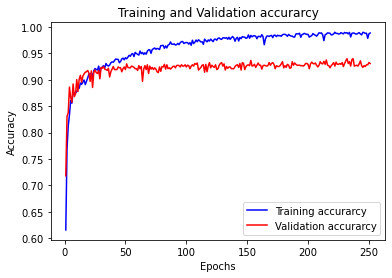

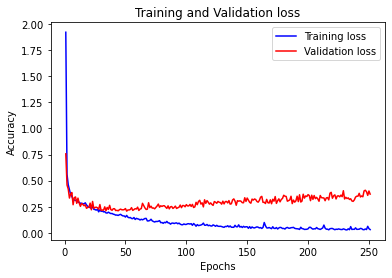

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
#Results on test dataset
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_BW_weights_1000.h5')
y_pred = saved_model.predict((X_test,W_test), batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
print(y_pred_bool)
rounded_labels=np.argmax(y_test, axis=1)
print(rounded_labels)
print(classification_report(rounded_labels, y_pred_bool))

32/32 [==============================] - 4s 124ms/step
[4 4 4 ... 2 4 2]
[4 4 4 ... 2 4 2]
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       263
           1       1.00      0.32      0.49        28
           2       0.90      0.91      0.90       523
           3       1.00      0.99      0.99       523
           4       0.92      0.98      0.95       680

    accuracy                           0.92      2017
   macro avg       0.93      0.79      0.82      2017
weighted avg       0.92      0.92      0.92      2017



In [17]:
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_BW_weights_1000.h5')

#score,accuracy,precision,recall = saved_model.evaluate(X_test,y_test,verbose=1)

score,accuracy,precision,recall = saved_model.evaluate((X_train,W_train),y_train,verbose=1)
print("train loss is {}".format(score))
print("train accuracy is {}".format(accuracy))
print("train Precision is {}".format(precision))
print("train Recall is {}".format(recall))
f1 = (2*(precision*recall))/(precision+recall)
print("train f1_score is {}".format(f1))

190/190 [==============================] - 9s 48ms/step - loss: 0.0672 - accuracy: 0.9878 - precision: 0.9879 - recall: 0.9874
train loss is 0.06718304753303528
train accuracy is 0.9877706170082092
train Precision is 0.9879298806190491
train Recall is 0.9874401092529297
train f1_score is 0.9876849342192648


Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 60, 60, 128)  3328        input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 30, 30, 128)  0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 30, 30, 128)  0           max_pooling2d_6[0][0]            
_______________________________________________________________________________________

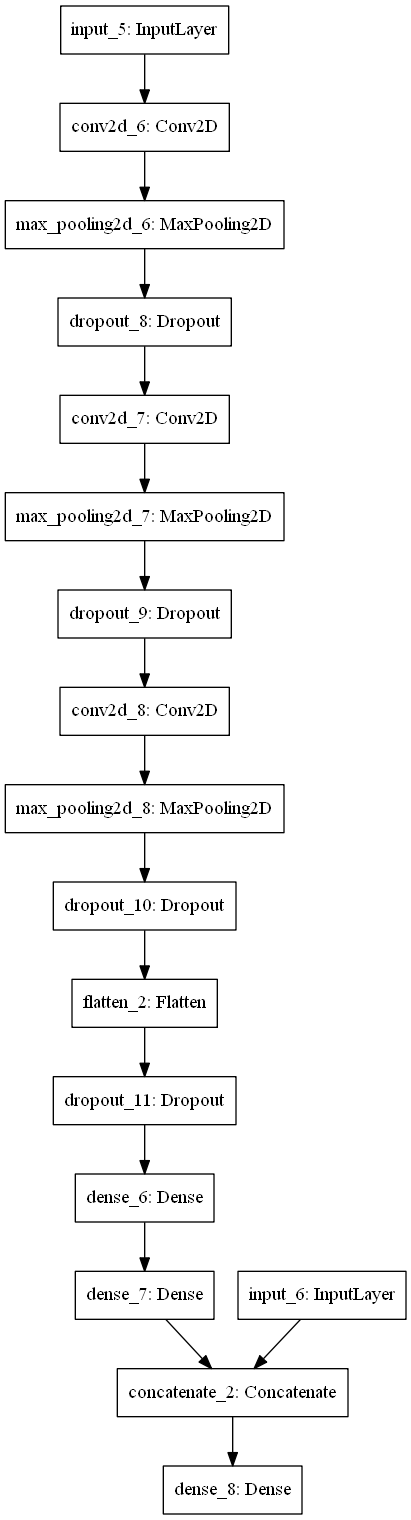

In [18]:
#Build the model
visible1 = Input(shape=(64,64,1))
#visible1 = Input(shape=(100,100,1))
# first feature extractor

conv1 = Conv2D(128, kernel_size=(5,5), activation='relu')(visible1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
dropout1=Dropout(0.2)(pool1)

conv2 = Conv2D(64, kernel_size=(3,3), activation='relu')(dropout1)
#conv2 = Conv2D(64, kernel_size=(3,3), activation='relu')
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
dropout2=Dropout(0.2)(pool2)

conv3 = Conv2D(64, kernel_size=(3,3), activation='relu')(dropout2)
#conv3 = Conv2D(64, kernel_size=(3,3), activation='relu')
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
dropout3=Dropout(0.2)(pool3)


flat1 = Flatten()(dropout3)
dropout4=Dropout(0.5)(flat1)
#### New entry to try concatentation
flat2 = Input(shape=(1))



#hidden1 = Dense(64, activation='relu')(merge)
hidden1 = Dense(64, activation='relu')(dropout4)
hidden2 = Dense(16, activation='relu')(hidden1)

hidden3 = Concatenate()([hidden2, flat2])
#regress=

## 

#output = Dense(5, activation='softmax')(hidden2)

output = Dense(5, activation='softmax')(hidden3)

model = Model(inputs=(visible1,flat2), outputs=output)
#model = Model(inputs=(visible1), outputs=output)
print(model.summary())
# plot graph
plot_model(model, to_file='convolutional_neural_network.png')

In [19]:
#Compile the model with hyperparameters
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', keras.metrics.Precision(),  keras.metrics.Recall()],
             )

In [20]:
#Run the model with 150 epochs
import time
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
start = time.perf_counter()
print(y_train.shape)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model_BW_weights_150.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history=model.fit((X_train,W_train), y_train, batch_size=64, epochs=150, validation_split=0.2,shuffle=1, callbacks=[es, mc], class_weight=None)

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

(6051, 5)
Epoch 1/150
76/76 [==============================] - ETA: 0s - loss: 1.7507 - accuracy: 0.6116 - precision_2: 0.6612 - recall_2: 0.5539
Epoch 00001: val_accuracy improved from -inf to 0.69282, saving model to best_model_BW_weights_150.h5
76/76 [==============================] - 41s 536ms/step - loss: 1.7507 - accuracy: 0.6116 - precision_2: 0.6612 - recall_2: 0.5539 - val_loss: 0.7098 - val_accuracy: 0.6928 - val_precision_2: 0.7475 - val_recall_2: 0.6284
Epoch 2/150
76/76 [==============================] - ETA: 0s - loss: 0.5941 - accuracy: 0.7698 - precision_2: 0.8153 - recall_2: 0.7176
Epoch 00002: val_accuracy did not improve from 0.69282
76/76 [==============================] - 41s 543ms/step - loss: 0.5941 - accuracy: 0.7698 - precision_2: 0.8153 - recall_2: 0.7176 - val_loss: 0.7307 - val_accuracy: 0.6755 - val_precision_2: 0.7013 - val_recall_2: 0.6416
Epoch 3/150
76/76 [==============================] - ETA: 0s - loss: 0.4881 - accuracy: 0.8087 - precision_2: 0.8495 

Epoch 40/150
76/76 [==============================] - ETA: 0s - loss: 0.1835 - accuracy: 0.9293 - precision_2: 0.9365 - recall_2: 0.9227
Epoch 00040: val_accuracy did not improve from 0.93146
76/76 [==============================] - 37s 487ms/step - loss: 0.1835 - accuracy: 0.9293 - precision_2: 0.9365 - recall_2: 0.9227 - val_loss: 0.2225 - val_accuracy: 0.9265 - val_precision_2: 0.9369 - val_recall_2: 0.9199
Epoch 41/150
76/76 [==============================] - ETA: 0s - loss: 0.1723 - accuracy: 0.9357 - precision_2: 0.9404 - recall_2: 0.9293
Epoch 00041: val_accuracy did not improve from 0.93146
76/76 [==============================] - 37s 493ms/step - loss: 0.1723 - accuracy: 0.9357 - precision_2: 0.9404 - recall_2: 0.9293 - val_loss: 0.2432 - val_accuracy: 0.9108 - val_precision_2: 0.9184 - val_recall_2: 0.9009
Epoch 42/150
76/76 [==============================] - ETA: 0s - loss: 0.1736 - accuracy: 0.9355 - precision_2: 0.9392 - recall_2: 0.9322
Epoch 00042: val_accuracy did not i

Epoch 60/150
76/76 [==============================] - ETA: 0s - loss: 0.1380 - accuracy: 0.9492 - precision_2: 0.9524 - recall_2: 0.9459
Epoch 00060: val_accuracy did not improve from 0.93476
76/76 [==============================] - 42s 557ms/step - loss: 0.1380 - accuracy: 0.9492 - precision_2: 0.9524 - recall_2: 0.9459 - val_loss: 0.2096 - val_accuracy: 0.9298 - val_precision_2: 0.9328 - val_recall_2: 0.9282
Epoch 61/150
76/76 [==============================] - ETA: 0s - loss: 0.1308 - accuracy: 0.9531 - precision_2: 0.9565 - recall_2: 0.9496
Epoch 00061: val_accuracy improved from 0.93476 to 0.93559, saving model to best_model_BW_weights_150.h5
76/76 [==============================] - 41s 536ms/step - loss: 0.1308 - accuracy: 0.9531 - precision_2: 0.9565 - recall_2: 0.9496 - val_loss: 0.2210 - val_accuracy: 0.9356 - val_precision_2: 0.9405 - val_recall_2: 0.9273
Epoch 62/150
76/76 [==============================] - ETA: 0s - loss: 0.1238 - accuracy: 0.9535 - precision_2: 0.9558 - re

Epoch 80/150
76/76 [==============================] - ETA: 0s - loss: 0.0946 - accuracy: 0.9674 - precision_2: 0.9685 - recall_2: 0.9651
Epoch 00080: val_accuracy did not improve from 0.93889
76/76 [==============================] - 41s 539ms/step - loss: 0.0946 - accuracy: 0.9674 - precision_2: 0.9685 - recall_2: 0.9651 - val_loss: 0.2576 - val_accuracy: 0.9323 - val_precision_2: 0.9344 - val_recall_2: 0.9298
Epoch 81/150
76/76 [==============================] - ETA: 0s - loss: 0.0866 - accuracy: 0.9649 - precision_2: 0.9658 - recall_2: 0.9632
Epoch 00081: val_accuracy did not improve from 0.93889
76/76 [==============================] - 41s 539ms/step - loss: 0.0866 - accuracy: 0.9649 - precision_2: 0.9658 - recall_2: 0.9632 - val_loss: 0.2639 - val_accuracy: 0.9232 - val_precision_2: 0.9313 - val_recall_2: 0.9182
Epoch 82/150
76/76 [==============================] - ETA: 0s - loss: 0.1003 - accuracy: 0.9667 - precision_2: 0.9681 - recall_2: 0.9649
Epoch 00082: val_accuracy did not i

Epoch 100/150
76/76 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9715 - precision_2: 0.9723 - recall_2: 0.9707
Epoch 00100: val_accuracy did not improve from 0.93889
76/76 [==============================] - 40s 530ms/step - loss: 0.0800 - accuracy: 0.9715 - precision_2: 0.9723 - recall_2: 0.9707 - val_loss: 0.2927 - val_accuracy: 0.9273 - val_precision_2: 0.9304 - val_recall_2: 0.9273
Epoch 101/150
76/76 [==============================] - ETA: 0s - loss: 0.0820 - accuracy: 0.9696 - precision_2: 0.9716 - recall_2: 0.9682
Epoch 00101: val_accuracy did not improve from 0.93889
76/76 [==============================] - 40s 529ms/step - loss: 0.0820 - accuracy: 0.9696 - precision_2: 0.9716 - recall_2: 0.9682 - val_loss: 0.2398 - val_accuracy: 0.9315 - val_precision_2: 0.9337 - val_recall_2: 0.9306
Epoch 102/150
76/76 [==============================] - ETA: 0s - loss: 0.0646 - accuracy: 0.9746 - precision_2: 0.9752 - recall_2: 0.9740
Epoch 00102: val_accuracy did no

Epoch 120/150
76/76 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9775 - precision_2: 0.9781 - recall_2: 0.9769
Epoch 00120: val_accuracy did not improve from 0.93889
76/76 [==============================] - 45s 597ms/step - loss: 0.0610 - accuracy: 0.9775 - precision_2: 0.9781 - recall_2: 0.9769 - val_loss: 0.2802 - val_accuracy: 0.9348 - val_precision_2: 0.9360 - val_recall_2: 0.9306
Epoch 121/150
76/76 [==============================] - ETA: 0s - loss: 0.0497 - accuracy: 0.9826 - precision_2: 0.9828 - recall_2: 0.9822
Epoch 00121: val_accuracy did not improve from 0.93889
76/76 [==============================] - 44s 580ms/step - loss: 0.0497 - accuracy: 0.9826 - precision_2: 0.9828 - recall_2: 0.9822 - val_loss: 0.2789 - val_accuracy: 0.9290 - val_precision_2: 0.9296 - val_recall_2: 0.9273
Epoch 122/150
76/76 [==============================] - ETA: 0s - loss: 0.0662 - accuracy: 0.9777 - precision_2: 0.9785 - recall_2: 0.9767
Epoch 00122: val_accuracy did no

Epoch 140/150
76/76 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9793 - precision_2: 0.9806 - recall_2: 0.9793
Epoch 00140: val_accuracy did not improve from 0.93972
76/76 [==============================] - 40s 532ms/step - loss: 0.0603 - accuracy: 0.9793 - precision_2: 0.9806 - recall_2: 0.9793 - val_loss: 0.2592 - val_accuracy: 0.9348 - val_precision_2: 0.9370 - val_recall_2: 0.9339
Epoch 141/150
76/76 [==============================] - ETA: 0s - loss: 0.0437 - accuracy: 0.9837 - precision_2: 0.9849 - recall_2: 0.9833
Epoch 00141: val_accuracy did not improve from 0.93972
76/76 [==============================] - 40s 523ms/step - loss: 0.0437 - accuracy: 0.9837 - precision_2: 0.9849 - recall_2: 0.9833 - val_loss: 0.2957 - val_accuracy: 0.9290 - val_precision_2: 0.9305 - val_recall_2: 0.9290
Epoch 142/150
76/76 [==============================] - ETA: 0s - loss: 0.0552 - accuracy: 0.9816 - precision_2: 0.9822 - recall_2: 0.9814
Epoch 00142: val_accuracy did no

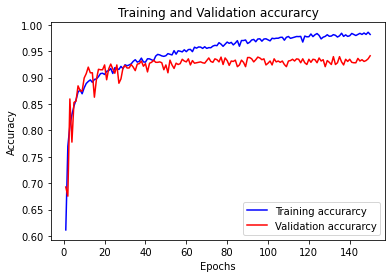

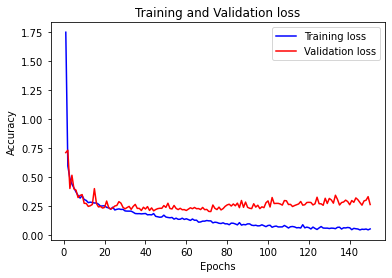

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
#Results on test dataset
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_BW_weights_150.h5')
y_pred = saved_model.predict((X_test,W_test), batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
print(y_pred_bool)
rounded_labels=np.argmax(y_test, axis=1)
print(rounded_labels)
print(classification_report(rounded_labels, y_pred_bool))

32/32 [==============================] - 4s 129ms/step
[4 4 4 ... 2 4 2]
[4 4 4 ... 2 4 2]
              precision    recall  f1-score   support

           0       0.77      0.82      0.80       263
           1       0.93      0.46      0.62        28
           2       0.93      0.90      0.91       523
           3       1.00      0.99      1.00       523
           4       0.94      0.97      0.96       680

    accuracy                           0.93      2017
   macro avg       0.91      0.83      0.86      2017
weighted avg       0.93      0.93      0.93      2017



In [23]:
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_BW_weights_150.h5')

#score,accuracy,precision,recall = saved_model.evaluate(X_test,y_test,verbose=1)

score,accuracy,precision,recall = saved_model.evaluate((X_train,W_train),y_train,verbose=1)
print("train loss is {}".format(score))
print("train accuracy is {}".format(accuracy))
print("train Precision is {}".format(precision))
print("train Recall is {}".format(recall))
f1 = (2*(precision*recall))/(precision+recall)
print("train f1_score is {}".format(f1))

190/190 [==============================] - 10s 53ms/step - loss: 0.0560 - accuracy: 0.9879 - precision_2: 0.9883 - recall_2: 0.9874
train loss is 0.05600438639521599
train accuracy is 0.9879359006881714
train Precision is 0.9882566928863525
train Recall is 0.9874401092529297
train f1_score is 0.9878482323168168


Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 60, 60, 128)  3328        input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 30, 30, 128)  0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, 30, 30, 128)  0           max_pooling2d_9[0][0]            
_______________________________________________________________________________________

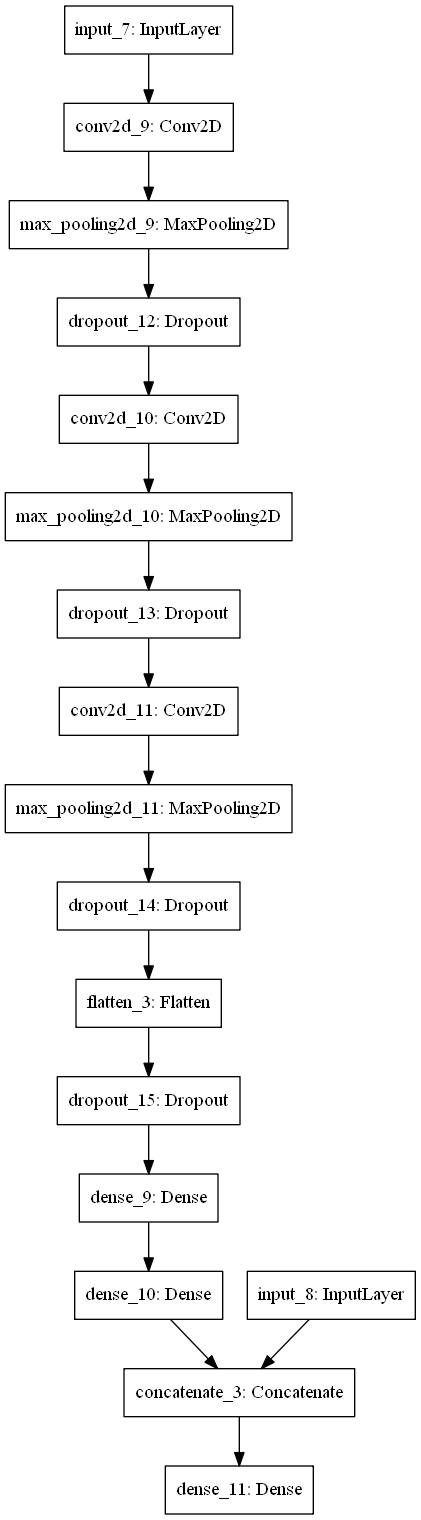

In [24]:
#Build the model
visible1 = Input(shape=(64,64,1))
#visible1 = Input(shape=(100,100,1))
# first feature extractor

conv1 = Conv2D(128, kernel_size=(5,5), activation='relu')(visible1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
dropout1=Dropout(0.2)(pool1)

conv2 = Conv2D(64, kernel_size=(3,3), activation='relu')(dropout1)
#conv2 = Conv2D(64, kernel_size=(3,3), activation='relu')
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
dropout2=Dropout(0.2)(pool2)

conv3 = Conv2D(64, kernel_size=(3,3), activation='relu')(dropout2)
#conv3 = Conv2D(64, kernel_size=(3,3), activation='relu')
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
dropout3=Dropout(0.2)(pool3)


flat1 = Flatten()(dropout3)
dropout4=Dropout(0.5)(flat1)
#### New entry to try concatentation
flat2 = Input(shape=(1))



#hidden1 = Dense(64, activation='relu')(merge)
hidden1 = Dense(64, activation='relu')(dropout4)
hidden2 = Dense(16, activation='relu')(hidden1)

hidden3 = Concatenate()([hidden2, flat2])
#regress=

## 

#output = Dense(5, activation='softmax')(hidden2)

output = Dense(5, activation='softmax')(hidden3)

model = Model(inputs=(visible1,flat2), outputs=output)
#model = Model(inputs=(visible1), outputs=output)
print(model.summary())
# plot graph
plot_model(model, to_file='convolutional_neural_network.png')

In [25]:
#Compile the model with hyperparameters
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', keras.metrics.Precision(),  keras.metrics.Recall()],
             )

In [26]:
#Run the model with 50 epochs
import time
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
start = time.perf_counter()
print(y_train.shape)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model_BW_weights_50.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history=model.fit((X_train,W_train), y_train, batch_size=64, epochs=50, validation_split=0.2,shuffle=1, callbacks=[es, mc], class_weight=None)

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

(6051, 5)
Epoch 1/50
76/76 [==============================] - ETA: 0s - loss: 2.0893 - accuracy: 0.4649 - precision_3: 0.5220 - recall_3: 0.3388
Epoch 00001: val_accuracy improved from -inf to 0.72172, saving model to best_model_BW_weights_50.h5
76/76 [==============================] - 42s 546ms/step - loss: 2.0893 - accuracy: 0.4649 - precision_3: 0.5220 - recall_3: 0.3388 - val_loss: 0.8062 - val_accuracy: 0.7217 - val_precision_3: 0.8519 - val_recall_3: 0.5178
Epoch 2/50
76/76 [==============================] - ETA: 0s - loss: 0.7823 - accuracy: 0.7112 - precision_3: 0.7715 - recall_3: 0.6440
Epoch 00002: val_accuracy improved from 0.72172 to 0.81090, saving model to best_model_BW_weights_50.h5
76/76 [==============================] - 40s 527ms/step - loss: 0.7823 - accuracy: 0.7112 - precision_3: 0.7715 - recall_3: 0.6440 - val_loss: 0.6090 - val_accuracy: 0.8109 - val_precision_3: 0.8548 - val_recall_3: 0.7680
Epoch 3/50
76/76 [==============================] - ETA: 0s - loss: 0.6

Epoch 20/50
76/76 [==============================] - ETA: 0s - loss: 0.2866 - accuracy: 0.8870 - precision_3: 0.9030 - recall_3: 0.8696
Epoch 00020: val_accuracy did not improve from 0.90008
76/76 [==============================] - 39s 519ms/step - loss: 0.2866 - accuracy: 0.8870 - precision_3: 0.9030 - recall_3: 0.8696 - val_loss: 0.2796 - val_accuracy: 0.8935 - val_precision_3: 0.9120 - val_recall_3: 0.8811
Epoch 21/50
76/76 [==============================] - ETA: 0s - loss: 0.2931 - accuracy: 0.8882 - precision_3: 0.9050 - recall_3: 0.8738
Epoch 00021: val_accuracy did not improve from 0.90008
76/76 [==============================] - 40s 522ms/step - loss: 0.2931 - accuracy: 0.8882 - precision_3: 0.9050 - recall_3: 0.8738 - val_loss: 0.2905 - val_accuracy: 0.8902 - val_precision_3: 0.9071 - val_recall_3: 0.8704
Epoch 22/50
76/76 [==============================] - ETA: 0s - loss: 0.2820 - accuracy: 0.8888 - precision_3: 0.9065 - recall_3: 0.8733
Epoch 00022: val_accuracy did not impr

Epoch 40/50
76/76 [==============================] - ETA: 0s - loss: 0.2028 - accuracy: 0.9176 - precision_3: 0.9252 - recall_3: 0.9101
Epoch 00040: val_accuracy improved from 0.92073 to 0.92155, saving model to best_model_BW_weights_50.h5
76/76 [==============================] - 38s 494ms/step - loss: 0.2028 - accuracy: 0.9176 - precision_3: 0.9252 - recall_3: 0.9101 - val_loss: 0.2536 - val_accuracy: 0.9216 - val_precision_3: 0.9281 - val_recall_3: 0.9059
Epoch 41/50
76/76 [==============================] - ETA: 0s - loss: 0.2114 - accuracy: 0.9205 - precision_3: 0.9287 - recall_3: 0.9120
Epoch 00041: val_accuracy did not improve from 0.92155
76/76 [==============================] - 38s 502ms/step - loss: 0.2114 - accuracy: 0.9205 - precision_3: 0.9287 - recall_3: 0.9120 - val_loss: 0.2643 - val_accuracy: 0.9050 - val_precision_3: 0.9092 - val_recall_3: 0.9017
Epoch 42/50
76/76 [==============================] - ETA: 0s - loss: 0.2245 - accuracy: 0.9169 - precision_3: 0.9235 - recall

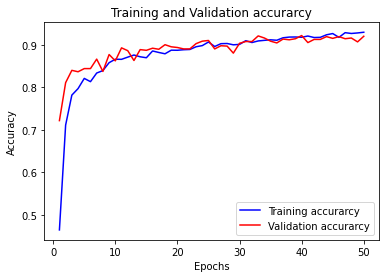

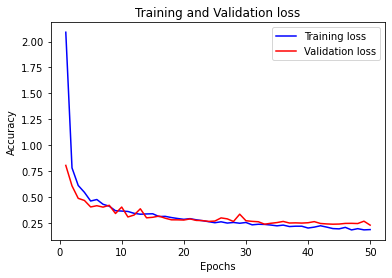

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
#Results on test dataset
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_BW_weights_50.h5')
y_pred = saved_model.predict((X_test,W_test), batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
print(y_pred_bool)
rounded_labels=np.argmax(y_test, axis=1)
print(rounded_labels)
print(classification_report(rounded_labels, y_pred_bool))

32/32 [==============================] - 4s 132ms/step
[4 0 4 ... 2 4 2]
[4 4 4 ... 2 4 2]
              precision    recall  f1-score   support

           0       0.76      0.78      0.77       263
           1       1.00      0.25      0.40        28
           2       0.90      0.90      0.90       523
           3       1.00      0.99      1.00       523
           4       0.93      0.96      0.95       680

    accuracy                           0.92      2017
   macro avg       0.92      0.78      0.80      2017
weighted avg       0.92      0.92      0.92      2017



In [29]:
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_BW_weights_50.h5')

#score,accuracy,precision,recall = saved_model.evaluate(X_test,y_test,verbose=1)

score,accuracy,precision,recall = saved_model.evaluate((X_train,W_train),y_train,verbose=1)
print("train loss is {}".format(score))
print("train accuracy is {}".format(accuracy))
print("train Precision is {}".format(precision))
print("train Recall is {}".format(recall))
f1 = (2*(precision*recall))/(precision+recall)
print("train f1_score is {}".format(f1))

190/190 [==============================] - 11s 58ms/step - loss: 0.1757 - accuracy: 0.9446 - precision_3: 0.9512 - recall_3: 0.9316
train loss is 0.175684854388237
train accuracy is 0.9446372389793396
train Precision is 0.951231837272644
train Recall is 0.9315815567970276
train f1_score is 0.9413041554011331


Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 60, 60, 128)  3328        input_9[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 30, 30, 128)  0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
dropout_16 (Dropout)            (None, 30, 30, 128)  0           max_pooling2d_12[0][0]           
_______________________________________________________________________________________

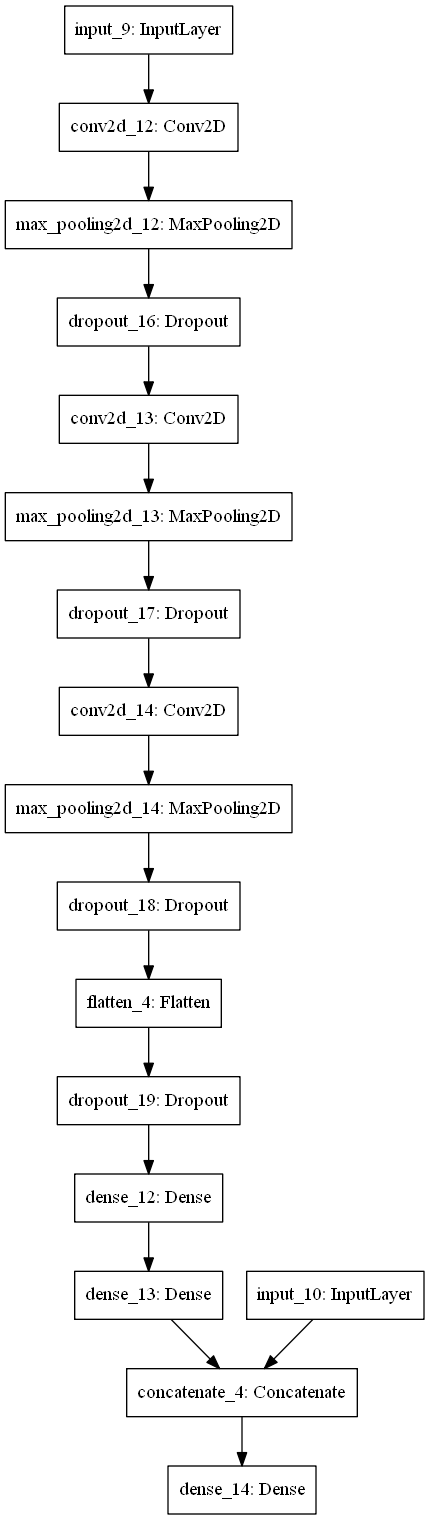

In [30]:
#Build the model
visible1 = Input(shape=(64,64,1))
#visible1 = Input(shape=(100,100,1))
# first feature extractor

conv1 = Conv2D(128, kernel_size=(5,5), activation='relu')(visible1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
dropout1=Dropout(0.2)(pool1)

conv2 = Conv2D(64, kernel_size=(3,3), activation='relu')(dropout1)
#conv2 = Conv2D(64, kernel_size=(3,3), activation='relu')
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
dropout2=Dropout(0.2)(pool2)

conv3 = Conv2D(64, kernel_size=(3,3), activation='relu')(dropout2)
#conv3 = Conv2D(64, kernel_size=(3,3), activation='relu')
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
dropout3=Dropout(0.2)(pool3)


flat1 = Flatten()(dropout3)
dropout4=Dropout(0.5)(flat1)
#### New entry to try concatentation
flat2 = Input(shape=(1))



#hidden1 = Dense(64, activation='relu')(merge)
hidden1 = Dense(64, activation='relu')(dropout4)
hidden2 = Dense(16, activation='relu')(hidden1)

hidden3 = Concatenate()([hidden2, flat2])
#regress=

## 

#output = Dense(5, activation='softmax')(hidden2)

output = Dense(5, activation='softmax')(hidden3)

model = Model(inputs=(visible1,flat2), outputs=output)
#model = Model(inputs=(visible1), outputs=output)
print(model.summary())
# plot graph
plot_model(model, to_file='convolutional_neural_network.png')

In [31]:
#Compile the model with hyperparameters
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', keras.metrics.Precision(),  keras.metrics.Recall()],
             )

In [32]:
#Run the model with 25 epochs
import time
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
start = time.perf_counter()
print(y_train.shape)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model_BW_weights_25.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history=model.fit((X_train,W_train), y_train, batch_size=64, epochs=25, validation_split=0.2,shuffle=1, callbacks=[es, mc], class_weight=None)

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

(6051, 5)
Epoch 1/25
76/76 [==============================] - ETA: 0s - loss: 1.7076 - accuracy: 0.5816 - precision_4: 0.6363 - recall_4: 0.4855
Epoch 00001: val_accuracy improved from -inf to 0.68456, saving model to best_model_BW_weights_25.h5
76/76 [==============================] - 41s 542ms/step - loss: 1.7076 - accuracy: 0.5816 - precision_4: 0.6363 - recall_4: 0.4855 - val_loss: 0.7225 - val_accuracy: 0.6846 - val_precision_4: 0.7624 - val_recall_4: 0.5590
Epoch 2/25
76/76 [==============================] - ETA: 0s - loss: 0.7120 - accuracy: 0.7045 - precision_4: 0.7646 - recall_4: 0.6308
Epoch 00002: val_accuracy improved from 0.68456 to 0.74319, saving model to best_model_BW_weights_25.h5
76/76 [==============================] - 40s 531ms/step - loss: 0.7120 - accuracy: 0.7045 - precision_4: 0.7646 - recall_4: 0.6308 - val_loss: 0.6100 - val_accuracy: 0.7432 - val_precision_4: 0.7978 - val_recall_4: 0.6680
Epoch 3/25
76/76 [==============================] - ETA: 0s - loss: 0.6

Epoch 20/25
76/76 [==============================] - ETA: 0s - loss: 0.2493 - accuracy: 0.9087 - precision_4: 0.9170 - recall_4: 0.8975
Epoch 00020: val_accuracy did not improve from 0.92320
76/76 [==============================] - 41s 536ms/step - loss: 0.2493 - accuracy: 0.9087 - precision_4: 0.9170 - recall_4: 0.8975 - val_loss: 0.2658 - val_accuracy: 0.9116 - val_precision_4: 0.9153 - val_recall_4: 0.8927
Epoch 21/25
76/76 [==============================] - ETA: 0s - loss: 0.2428 - accuracy: 0.9097 - precision_4: 0.9167 - recall_4: 0.9025
Epoch 00021: val_accuracy did not improve from 0.92320
76/76 [==============================] - 43s 559ms/step - loss: 0.2428 - accuracy: 0.9097 - precision_4: 0.9167 - recall_4: 0.9025 - val_loss: 0.2786 - val_accuracy: 0.9009 - val_precision_4: 0.9223 - val_recall_4: 0.8728
Epoch 22/25
76/76 [==============================] - ETA: 0s - loss: 0.2432 - accuracy: 0.9074 - precision_4: 0.9159 - recall_4: 0.8977
Epoch 00022: val_accuracy did not impr

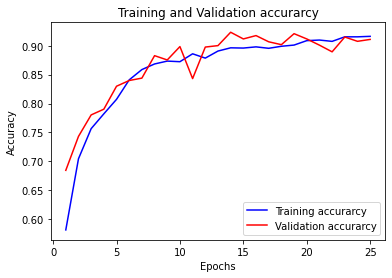

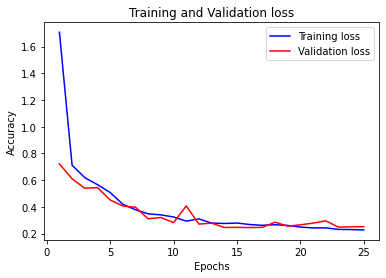

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
#Results on test dataset
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_BW_weights_25.h5')
y_pred = saved_model.predict((X_test,W_test), batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
print(y_pred_bool)
rounded_labels=np.argmax(y_test, axis=1)
print(rounded_labels)
print(classification_report(rounded_labels, y_pred_bool))

32/32 [==============================] - 4s 121ms/step
[4 4 4 ... 2 4 2]
[4 4 4 ... 2 4 2]
              precision    recall  f1-score   support

           0       0.72      0.71      0.72       263
           1       1.00      0.07      0.13        28
           2       0.86      0.88      0.87       523
           3       0.99      1.00      0.99       523
           4       0.94      0.95      0.94       680

    accuracy                           0.90      2017
   macro avg       0.90      0.72      0.73      2017
weighted avg       0.90      0.90      0.90      2017



In [35]:
from tensorflow.keras.models import load_model
saved_model = load_model('best_model_BW_weights_25.h5')

#score,accuracy,precision,recall = saved_model.evaluate(X_test,y_test,verbose=1)

score,accuracy,precision,recall = saved_model.evaluate((X_train,W_train),y_train,verbose=1)
print("train loss is {}".format(score))
print("train accuracy is {}".format(accuracy))
print("train Precision is {}".format(precision))
print("train Recall is {}".format(recall))
f1 = (2*(precision*recall))/(precision+recall)
print("train f1_score is {}".format(f1))

190/190 [==============================] - 11s 57ms/step - loss: 0.2182 - accuracy: 0.9258 - precision_4: 0.9340 - recall_4: 0.9144 4
train loss is 0.21815018355846405
train accuracy is 0.9257974028587341
train Precision is 0.9339972734451294
train Recall is 0.9143943190574646
train f1_score is 0.924091847547385
